In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.optimize import root_scalar

# Constants
G = 6.67430e-11  # Gravitational constant in N*m^2/kg^2
M_sun = 1.989e30  # Solar mass in kg
R_sun = 6.955e8  # Solar radius in m
#K_NR = 1.2435e15  # Constant for non-relativistic electron degenerate gas (cgs units)
m_e = 9.11e-31 #Electron mass in kg
mu_e = 2  # Mean molecular weight per electron (assume fully ionized He)
hbar = 1.05457182e-34 #Reduced Planck constant in Js^-1
h = 6.626068e-34
c = 2.99e8 #Speed of light in ms^-1
a_z = 2
m_p = 1.67e-27 #Neutron mass in kg
lambda_e = hbar / (m_e * c) #Compton wavelength

In [12]:


# # Fully relativistic energy density
# def calc_energy_density(rho):
#     p_F = calc_p_F(rho) / (m_e * c)  # Normalize p_F to mc units
#     integrand = lambda p: (np.sqrt(1 + p**2) - 1)  # Energy integrand
#     KE, _ = quad(integrand, 0, p_F)  # Integrate from 0 to p_F
#     return KE * (hbar * c / (m_e * c)**4)  # Convert back to SI units

2.4665901059369118e+23

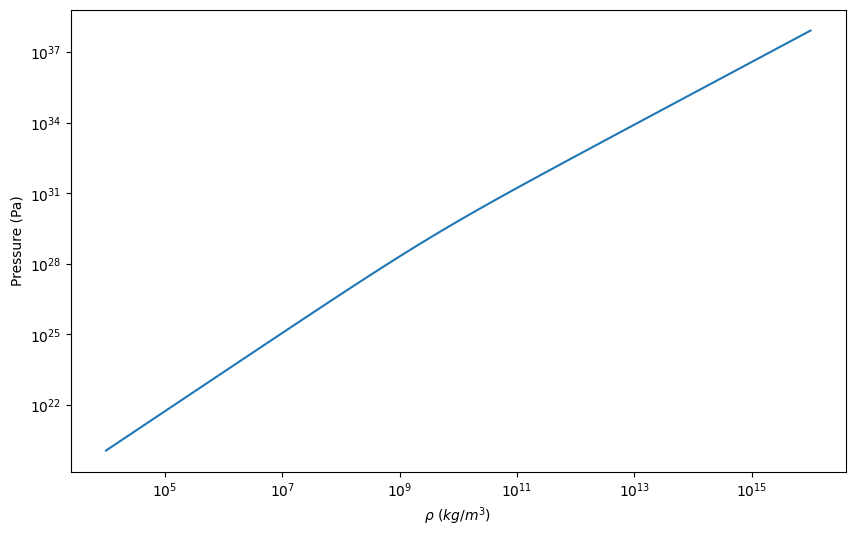

In [13]:
# Fermi momentum from density
def calc_p_f(rho):
    n_e = rho / (mu_e * m_p)  # Number density of electrons
    return hbar * (3 * np.pi**2 * n_e)**(1/3)

def calc_pressure(rho):
    p_f = calc_p_f(rho)
    x = p_f / (m_e * c)
    
    psi = lambda x: (x*(1+x**2)**(1/2))*((2*x**2)/3 -1)+ np.log(x + (1+x**2)**(1/2))
    return ((m_e * c**2) / lambda_e**3) * psi(x) *1e5 #Convert from dyne/cm^2 to Pa



"""Neglect energy density of electrons"""

# def calc_energy_density(rho):
#     p_f = calc_p_f(rho)
#     x = p_f / (m_e * c)
#     chi = lambda x: (x*(1+x**2)**(1/2))*(1+2*x**2) - np.log(x + (1+x**2)**(1/2))
#     return ((m_e * c**2) / lambda_e**3) * chi(x)


test_rho_values = np.logspace(4,16,100)

pressures = [calc_pressure(rho) for rho in test_rho_values]

plt.figure(figsize = (10,6))
plt.loglog(test_rho_values, pressures, label="Fully Relativistic EOS")
plt.xlabel(r"$\rho$ $(kg/m^{3})$ ")
plt.ylabel(r"Pressure (Pa)")

calc_pressure(1e6)
# calc_energy_density(1e6)



In [14]:
'''def eos(P=None, rho=None):
    """
    Equation of State (EOS) for a white dwarf.
    Computes density from pressure or pressure from density using the full relativistic formulation.
    """
    if P is None and rho is None:
        raise ValueError("Either pressure (P) or density (rho) must be provided.")
    
    if P is not None:
        # Find rho that satisfies P = calc_pressure(rho)
        from scipy.optimize import root_scalar
        def pressure_residual(rho_guess):
            return calc_pressure(rho_guess) - P
        
        sol = root_scalar(pressure_residual, bracket=[1e4, 1e12], method='brentq')  # Adjust bounds as needed
        if sol.converged:
            return sol.root
        else:
            raise ValueError("Failed to find rho for given P.")
    
    elif rho is not None:
        return calc_pressure(rho)
'''

def eos(P=None, rho=None):
    #Calculate P given rho
    if rho is not None:
        return calc_pressure(rho)
    #Calculate rho given P
    elif P is not None:
        # Find the density corresponding to the given pressure
        def pressure_root(rho_guess):
            return calc_pressure(rho_guess) - P

        # Use a numerical solver to find rho
        result = root_scalar(pressure_root, bracket=[0, 1e30], method='brentq', xtol=1e-6, maxiter=1000)
        print(result.root, result.iterations, result.function_calls)
        print(result.converged)
        if result.converged:
            return result.root  # Return the density value
        else:
            raise ValueError("Root-finding did not converge. Check your input pressure value or function.")
    else:
        raise ValueError("Either P or rho must be provided.")
    
    

In [32]:
m_n = 1.67e-27
c1 = (h/(m_e * c) * (3/(8*np.pi*mu_e*m_n))**(1/3))
K = m_e * c**2 / lambda_e**3
alpha = np.sqrt((K*c1**5)/(36*np.pi**3*G))

Ni = 100000
Np = 100

rho = np.zeros((Ni,Np))
zed = np.zeros((Ni,Np))

xi = np.linspace(1e-5, 5, Ni)
dxi = (xi[1] - xi[0])
xi_zero = np.zeros(Np)
arg_zero = np.zeros(Np)
zed_zero = np.zeros(Np)

rho_0 = np.logspace(4, 15, Np)

############RK2##############
for j in range(0, Np):
    rho[0,j] = rho_0[j]
    zed[0,j] = 0
    for i in range(0, Ni-1):
        if rho[i,j] > 0:
            RHO = rho[i,j] - dxi/2 * (zed[i,j] * (rho[i,j]**(1/3)/xi[i]**2 * np.sqrt(1+c1**2*rho[i,j]**(2/3))))

            ZED = zed[i,j] + dxi/2 * (xi[i]**2 * rho[i,j])

            xi2 = (xi[i+1] + xi[i])/2

            rho[i+1,j] = rho[i,j] - dxi * (ZED * (RHO**(1/3)/xi2**2) * np.sqrt(1+c1**2*RHO**(2/3)))
            zed[i+1,j] = zed[i,j] + dxi * (xi2**2* RHO)
        else:
            xi_zero[j] = xi[i]
            arg_zero[j] = int(i)
            zed_zero[j] = zed[i,j]
            break

################################

Radii = xi_zero * alpha
Radii = Radii / 1000

M = 4*np.pi*alpha**3 * zed_zero
M = M/M_sun

C:\Users\Lenovo ThinkPad\AppData\Local\Temp\ipykernel_14128\2999872775.py:32: RuntimeWarning: invalid value encountered in scalar power
  rho[i+1,j] = rho[i,j] - dxi * (ZED * (RHO**(1/3)/xi2**2) * np.sqrt(1+c1**2*RHO**(2/3)))


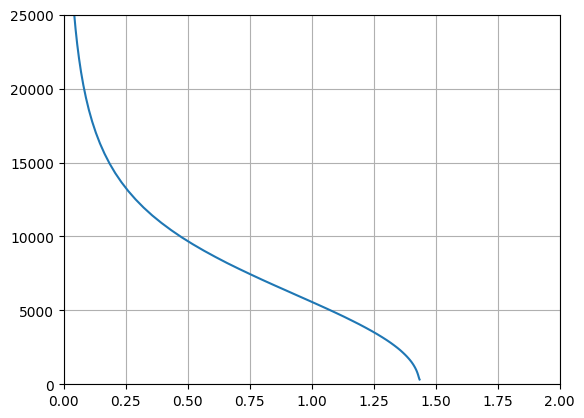

In [31]:
plt.plot(M,Radii)
plt.ylim(0,25000)
plt.xlim(0,2)
plt.grid()
